In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10543128031233098138,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3665166336
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15612622481082752438
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

---
## 데이터 전처리
---

In [3]:
DATA_DIR = ''
image_size = 128
batch_size = 32

In [4]:
train_df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017-train_df.csv')
valid_df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017-valid_df.csv')
test_df = pd.read_csv(f'{DATA_DIR}Data_Entry_2017-test_df.csv')

In [5]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00005401_000.png,Cardiomegaly,0,5401,44,F,PA,2048,2500,0.171000,0.171000
1,00005425_000.png,Cardiomegaly,0,5425,48,M,PA,2992,2991,0.143000,0.143000
2,00005426_000.png,Cardiomegaly,0,5426,41,F,PA,2048,2500,0.171000,0.171000
3,00005434_004.png,Cardiomegaly,4,5434,44,F,AP,2500,2048,0.168000,0.168000
4,00005516_000.png,Cardiomegaly,0,5516,53,F,AP,2048,2500,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
3395,00027292_000_Apply_Image_Effects.png,Cardiomegaly,0,27292,26,F,AP,3056,2544,0.139000,0.139000
3396,00027292_001_Apply_Image_Effects.png,Cardiomegaly,1,27292,26,F,AP,3056,2544,0.139000,0.139000
3397,00027334_000_Apply_Image_Effects.png,Cardiomegaly,0,27334,25,F,PA,2021,2021,0.194311,0.194311
3398,00027374_000_Apply_Image_Effects.png,Cardiomegaly,0,27374,57,F,PA,2021,2021,0.194311,0.194311


In [6]:
valid_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00004344_041.png,Cardiomegaly,41,4344,48,F,AP,2048,2500,0.168,0.168
1,00004344_043.png,Cardiomegaly,43,4344,48,F,AP,2500,2048,0.168,0.168
2,00004344_046.png,Cardiomegaly,46,4344,48,F,PA,2826,2729,0.143,0.143
3,00004363_000.png,Cardiomegaly,0,4363,36,M,PA,2048,2500,0.171,0.171
4,00004381_001.png,Cardiomegaly,1,4381,29,M,PA,2992,2981,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
195,00000181_057.png,No Finding,57,181,50,F,PA,2992,2991,0.143,0.143
196,00000181_063.png,No Finding,63,181,55,F,AP,3028,2544,0.139,0.139
197,00000181_064.png,No Finding,64,181,55,F,AP,3056,2544,0.139,0.139
198,00000181_065.png,No Finding,65,181,55,F,AP,3056,2544,0.139,0.139


In [7]:
test_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000008_000.png,Cardiomegaly,0,8,69,F,PA,2048,2500,0.171,0.171
2,00000013_045.png,Cardiomegaly,45,13,56,M,PA,2992,2991,0.143,0.143
3,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168
4,00000032_021.png,Cardiomegaly,21,32,55,F,AP,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
395,00000133_002.png,No Finding,2,133,68,M,AP,3056,2544,0.139,0.139
396,00000135_000.png,No Finding,0,135,70,M,PA,2500,2048,0.168,0.168
397,00000135_001.png,No Finding,1,135,70,M,AP,2500,2048,0.168,0.168
398,00000136_000.png,No Finding,0,136,58,F,PA,2750,2657,0.143,0.143


In [8]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}

In [9]:
train_df['path'] = train_df['Image Index'].map(data_image_paths.get)
valid_df['path'] = valid_df['Image Index'].map(data_image_paths.get)
test_df['path'] = test_df['Image Index'].map(data_image_paths.get)

In [10]:
labels = np.unique(list(chain(*train_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = np.unique(list(chain(*valid_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = np.unique(list(chain(*test_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]

In [11]:
all_labels = labels
#all_labels

In [12]:
for label in labels:
    if len(label) > 1:
        train_df[label] = train_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)
        valid_df[label] = valid_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)
        test_df[label] = test_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0.0)

In [13]:
#df.head()

In [14]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Cardiomegaly,No Finding
0,00005401_000.png,Cardiomegaly,0,5401,44,F,PA,2048,2500,0.171000,0.171000,images\images\00005401_000.png,1.0,0.0
1,00005425_000.png,Cardiomegaly,0,5425,48,M,PA,2992,2991,0.143000,0.143000,images\images\00005425_000.png,1.0,0.0
2,00005426_000.png,Cardiomegaly,0,5426,41,F,PA,2048,2500,0.171000,0.171000,images\images\00005426_000.png,1.0,0.0
3,00005434_004.png,Cardiomegaly,4,5434,44,F,AP,2500,2048,0.168000,0.168000,images\images\00005434_004.png,1.0,0.0
4,00005516_000.png,Cardiomegaly,0,5516,53,F,AP,2048,2500,0.168000,0.168000,images\images\00005516_000.png,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,00027292_000_Apply_Image_Effects.png,Cardiomegaly,0,27292,26,F,AP,3056,2544,0.139000,0.139000,images\images\00027292_000_Apply_Image_Effects...,1.0,0.0
3396,00027292_001_Apply_Image_Effects.png,Cardiomegaly,1,27292,26,F,AP,3056,2544,0.139000,0.139000,images\images\00027292_001_Apply_Image_Effects...,1.0,0.0
3397,00027334_000_Apply_Image_Effects.png,Cardiomegaly,0,27334,25,F,PA,2021,2021,0.194311,0.194311,images\images\00027334_000_Apply_Image_Effects...,1.0,0.0
3398,00027374_000_Apply_Image_Effects.png,Cardiomegaly,0,27374,57,F,PA,2021,2021,0.194311,0.194311,images\images\00027374_000_Apply_Image_Effects...,1.0,0.0


In [15]:
from sklearn.utils import shuffle

train_df= shuffle(train_df, random_state=2021)
valid_df= shuffle(valid_df, random_state=2021)
test_df= shuffle(test_df, random_state=2021)


#train_df, valid_df, test_df = shuffle(train_df, valid_df, test_df, random_state=2021)

In [16]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Cardiomegaly,No Finding
1426,00000538_003.png,No Finding,3,538,75,F,PA,2506,2991,0.143,0.143,images\images\00000538_003.png,0.0,1.0
1804,00000716_003.png,No Finding,3,716,33,F,PA,2992,2991,0.143,0.143,images\images\00000716_003.png,0.0,1.0
2072,00000831_000.png,No Finding,0,831,17,M,AP,2048,2500,0.171,0.171,images\images\00000831_000.png,0.0,1.0
203,00010728_000.png,Cardiomegaly,0,10728,20,F,PA,2992,2991,0.143,0.143,images\images\00010728_000.png,1.0,0.0
1776,00000702_003.png,No Finding,3,702,26,F,PA,2586,2991,0.143,0.143,images\images\00000702_003.png,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006,00000808_003.png,No Finding,3,808,51,F,AP,3056,2544,0.139,0.139,images\images\00000808_003.png,0.0,1.0
2669,00004892_000_Apply_Image_Effects.png,Cardiomegaly,0,4892,39,F,PA,2048,2500,0.171,0.171,images\images\00004892_000_Apply_Image_Effects...,1.0,0.0
1152,00000422_003.png,No Finding,3,422,75,F,PA,2500,2048,0.168,0.168,images\images\00000422_003.png,0.0,1.0
2105,00000853_000.png,No Finding,0,853,13,F,PA,2048,2500,0.171,0.171,images\images\00000853_000.png,0.0,1.0


In [17]:
'''
from sklearn.model_selection import train_test_split

train_df_1, train_df_temp_ = train_test_split(train_df, 
                                               test_size=0.5, 
                                               random_state=2021, shuffle=True, stratify=train_df['Finding Labels'])

valid_df_1, valid_df_temp = train_test_split(valid_df, 
                                               test_size=0.5, 
                                               random_state=2021, shuffle=True, stratify=valid_df['Finding Labels'])

test_df_1, test_df_temp = train_test_split(test_df, 
                                               test_size=0.5, 
                                               random_state=2021, shuffle=True, stratify=test_df['Finding Labels'])
'''

"\nfrom sklearn.model_selection import train_test_split\n\ntrain_df_1, train_df_temp_ = train_test_split(train_df, \n                                               test_size=0.5, \n                                               random_state=2021, shuffle=True, stratify=train_df['Finding Labels'])\n\nvalid_df_1, valid_df_temp = train_test_split(valid_df, \n                                               test_size=0.5, \n                                               random_state=2021, shuffle=True, stratify=valid_df['Finding Labels'])\n\ntest_df_1, test_df_temp = train_test_split(test_df, \n                                               test_size=0.5, \n                                               random_state=2021, shuffle=True, stratify=test_df['Finding Labels'])\n"

In [18]:
print(f'train_df {train_df.shape[0]} valid_df {valid_df.shape[0]} test_df {test_df.shape[0]}')

train_df 3400 valid_df 200 test_df 400


In [19]:
train_df['Finding Labels'].value_counts()

No Finding      1700
Cardiomegaly    1700
Name: Finding Labels, dtype: int64

In [20]:
valid_df['Finding Labels'].value_counts()

No Finding      100
Cardiomegaly    100
Name: Finding Labels, dtype: int64

In [21]:
test_df['Finding Labels'].value_counts()

No Finding      200
Cardiomegaly    200
Name: Finding Labels, dtype: int64

In [22]:
#test_df

In [23]:
train_df['labels'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
valid_df['labels'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
test_df['labels'] = test_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

<ipython-input-23-9730b6e19607>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
<ipython-input-23-9730b6e19607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['labels'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
<ipython-input-23-9730b6e19607>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [24]:
#train_df

In [25]:
core_idg = ImageDataGenerator(rescale=1 / 255)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_gen = core_idg.flow_from_dataframe(dataframe=test_df,
                                             directory=None,
                                             x_col='path',
                                             y_col='labels',
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))


valid_X, valid_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=512,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=test_df,
                                                       directory=None,
                                                       x_col='path',
                                                       y_col='labels',
                                                       class_mode='categorical',
                                                       batch_size=512,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 3400 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


---
## 네트워크 모델 정의후 데이터 연결, 학습 진행, 모델 저장
---

In [26]:
import tensorflow as tf
model = tf.keras.applications.DenseNet121(input_shape=(image_size, image_size, 3), weights=None, include_top=True, classes=2)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [27]:
'''
import tensorflow as tf
base_model = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)
base_model.summary()
'''

"\nimport tensorflow as tf\nbase_model = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)\nbase_model.summary()\n"

In [28]:
from keras.metrics import AUC
import keras


model.compile(optimizer='adam', 
              loss = 'binary_crossentropy', 
              metrics = [AUC(name='AUC'), 'accuracy'])

In [29]:
history = model.fit(train_gen,
                    epochs=50,
                    validation_data=(valid_X, valid_Y),)

Epoch 1/50
107/107 [==============================] - 66s 471ms/step - loss: 0.4714 - AUC: 0.8051 - accuracy: 0.7626 - val_loss: 0.7054 - val_AUC: 0.8425 - val_accuracy: 0.5900
Epoch 2/50
107/107 [==============================] - 45s 419ms/step - loss: 0.4245 - AUC: 0.8485 - accuracy: 0.7824 - val_loss: 0.6962 - val_AUC: 0.8542 - val_accuracy: 0.5350
Epoch 3/50
107/107 [==============================] - 45s 419ms/step - loss: 0.3812 - AUC: 0.8618 - accuracy: 0.8029 - val_loss: 0.5669 - val_AUC: 0.8682 - val_accuracy: 0.6950
Epoch 4/50
107/107 [==============================] - 45s 422ms/step - loss: 0.3686 - AUC: 0.8733 - accuracy: 0.8191 - val_loss: 0.7795 - val_AUC: 0.8763 - val_accuracy: 0.5600
Epoch 5/50
107/107 [==============================] - 45s 423ms/step - loss: 0.3364 - AUC: 0.8810 - accuracy: 0.8338 - val_loss: 1.1675 - val_AUC: 0.8829 - val_accuracy: 0.5000
Epoch 6/50
107/107 [==============================] - 45s 421ms/step - loss: 0.3335 - AUC: 0.8852 - accuracy: 0.838

107/107 [==============================] - 46s 433ms/step - loss: 0.0335 - AUC: 0.9728 - accuracy: 0.9868 - val_loss: 1.6749 - val_AUC: 0.9729 - val_accuracy: 0.5900
Epoch 48/50
107/107 [==============================] - 46s 427ms/step - loss: 0.0426 - AUC: 0.9730 - accuracy: 0.9862 - val_loss: 1.1061 - val_AUC: 0.9733 - val_accuracy: 0.7600
Epoch 49/50
107/107 [==============================] - 46s 429ms/step - loss: 0.0105 - AUC: 0.9736 - accuracy: 0.9965 - val_loss: 1.5110 - val_AUC: 0.9738 - val_accuracy: 0.7200
Epoch 50/50
107/107 [==============================] - 46s 428ms/step - loss: 0.0227 - AUC: 0.9741 - accuracy: 0.9932 - val_loss: 1.6149 - val_AUC: 0.9743 - val_accuracy: 0.6900


In [48]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('history_df.csv')
history_df

,loss,AUC,accuracy,val_loss,val_AUC,val_accuracy
0,0.471394,0.805107,0.762647,0.705375,0.842483,0.590
1,0.424547,0.848495,0.782353,0.696216,0.854233,0.535
2,0.381210,0.861764,0.802941,0.566893,0.868207,0.695
3,0.368599,0.873342,0.819118,0.779513,0.876299,0.560
4,0.336421,0.881011,0.833824,1.167491,0.882899,0.500
5,0.333487,0.885196,0.838235,1.175056,0.887103,0.535
6,0.310196,0.889840,0.850294,0.835731,0.892589,0.575
7,0.276998,0.896082,0.875000,0.655857,0.899330,0.650
8,0.257341,0.902557,0.880588,0.638140,0.905742,0.745
9,0.253757,0.908666,0.883824,0.980125,0.910465,0.560


Minimum validation loss: 0.4553622901439667
Maximum validation accuracy: 0.8299999833106995


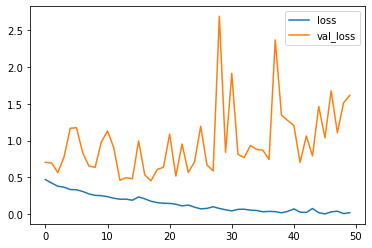

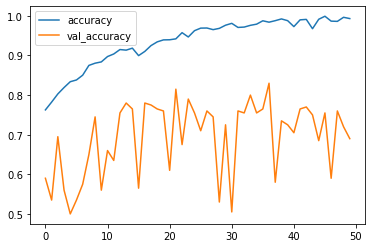

In [49]:
history_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig('loss,val_loss.png')
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig('accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(history_df['val_accuracy'].max()))

### validation_data 에 대한 정보

In [50]:
for c_label, s_count in zip(all_labels, 100*np.mean(valid_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Cardiomegaly: 50.00%
No Finding: 50.00%


In [51]:
valid_pred_Y = model.predict(valid_X, batch_size = 32, verbose = True)

7/7 [==============================] - 0s 37ms/step


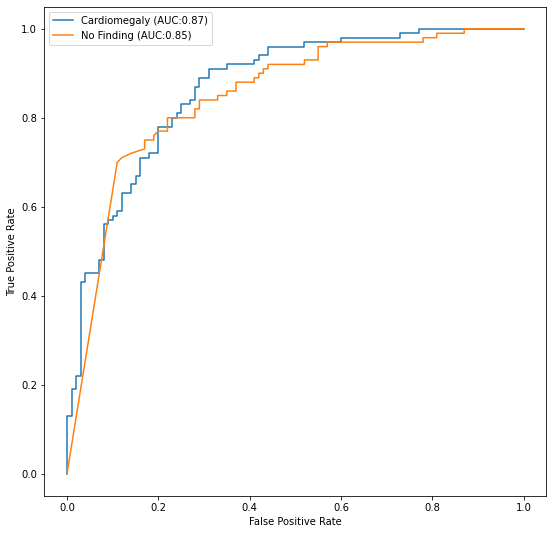

In [52]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(valid_Y[:,idx].astype(int), valid_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('valid_trained_net.png')

In [53]:
from sklearn.metrics import roc_auc_score
# ROC AUC
auc = roc_auc_score(valid_Y, valid_pred_Y)
print('ROC AUC: %f' % auc)

ROC AUC: 0.858275


### test_data 에 대한 정보

In [54]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Cardiomegaly: 50.00%
No Finding: 50.00%


In [55]:
test_pred_Y = model.predict(test_X, batch_size = 32, verbose = True)

13/13 [==============================] - 0s 34ms/step


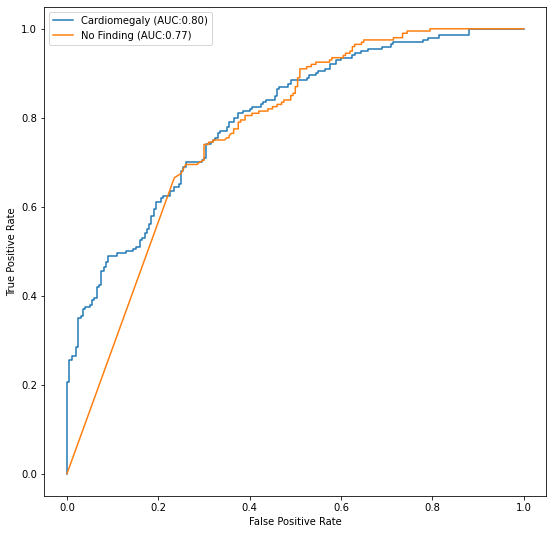

In [56]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), test_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('test_trained_net.png')

In [57]:
from sklearn.metrics import roc_auc_score
# ROC AUC
auc = roc_auc_score(test_Y, test_pred_Y)
print('ROC AUC: %f' % auc)

ROC AUC: 0.784400


### test 셋에 대한 평가

In [58]:
### https://www.tensorflow.org/guide/keras/train_and_evaluate?hl=ko
### https://wikidocs.net/32105
### evaluate()를 통해 테스트 데이터에 대해 모델을 평가합니다.

In [59]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_X, test_Y, batch_size=128, return_dict=True)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_X[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
4/4 [==============================] - 0s 74ms/step - loss: 2.3315 - AUC: 0.9729 - accuracy: 0.6475
test loss, test acc: {'loss': 2.3314664363861084, 'AUC': 0.9728928804397583, 'accuracy': 0.6474999785423279}
Generate predictions for 3 samples
predictions shape: (3, 2)


In [60]:
predictions=pd.DataFrame(predictions)
predictions.to_csv("predictions.csv")

In [61]:
pd.DataFrame(predictions)

,0,1
0,5.637154e-07,0.999999
1,4.803190e-12,1.000000
2,1.410993e-04,0.999859


In [62]:
test_X[:3]

array([[[[0.07058824, 0.07058824, 0.07058824],
         [0.07058824, 0.07058824, 0.07058824],
         [0.05490196, 0.05490196, 0.05490196],
         ...,
         [0.05490196, 0.05490196, 0.05490196],
         [0.05490196, 0.05490196, 0.05490196],
         [0.05882353, 0.05882353, 0.05882353]],

        [[0.0509804 , 0.0509804 , 0.0509804 ],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         [0.0509804 , 0.0509804 , 0.0509804 ],
         ...,
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353]],

        [[0.04705883, 0.04705883, 0.04705883],
         [0.04705883, 0.04705883, 0.04705883],
         [0.04705883, 0.04705883, 0.04705883],
         ...,
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353],
         [0.05882353, 0.05882353, 0.05882353]],

        ...,

        [[0.09019608, 0.09019608, 0.09019608],
         [0.08235294, 0.08235294, 0.08235294]

In [63]:
test_df[:3]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Cardiomegaly,No Finding,labels
243,00000032_022.png,No Finding,22,32,55,F,AP,2500,2048,0.168,0.168,images\images\00000032_022.png,0.0,1.0,[No Finding]
124,00003014_000.png,Cardiomegaly,0,3014,26,F,PA,2048,2500,0.171,0.171,images\images\00003014_000.png,1.0,0.0,[Cardiomegaly]
342,00000091_007.png,No Finding,7,91,70,M,AP,2500,2048,0.168,0.168,images\images\00000091_007.png,0.0,1.0,[No Finding]


In [64]:
test_df.to_csv("test_df.csv")

### 모델 저장

In [65]:
model.save('model.h5')
model.save_weights('model_weights.h5')